### Install dependencies

In [1]:
!pip install fair-esm

## Import libraries

In [2]:
import itertools
import os
import string
from pathlib import Path
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from scipy.spatial.distance import squareform, pdist, cdist
from Bio import SeqIO
from tqdm import tqdm
import esm
from esm import pretrained
from esm.data import ESMStructuralSplitDataset
import gc

# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Set device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Functions

### Parsing sequences from fasta (adapted from from original MSA parsing)

In [3]:
# Delete lowercase characters and insertion characters from string (maybe not necessary for fastas pulled from PDB_IDs?)
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads first (reference) sequence from fasta file."""
    record = next(SeqIO.parse(filename, "fasta"))
    # original .a3m MSAs have the first 3 AAs truncated compared to fasta?
    #sequence = str(record.seq)[3:]
    return record.description, str(record.seq)
    #return record.description, sequence


def remove_insertions(sequence: str) -> str:
    """ Removes insertions from sequence. """
    return sequence.translate(translation)

In [4]:
# # This is an efficient way to delete lowercase characters and insertion characters from a string
# deletekeys = dict.fromkeys(string.ascii_lowercase)
# deletekeys["."] = None
# deletekeys["*"] = None
# translation = str.maketrans(deletekeys)

# def read_sequence(filename: str) -> Tuple[str, str]:
#     """ Reads the first (reference) sequences from a fasta or MSA file."""
#     record = next(SeqIO.parse(filename, "fasta"))
#     return record.description, str(record.seq)

# def remove_insertions(sequence: str) -> str:
#     """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
#     return sequence.translate(translation)

# def read_msa(filename: str) -> List[Tuple[str, str]]:
#     """ Reads the sequences from an MSA file, automatically removes insertions."""
#     return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

### Converting structures to contacts

Use 15 angstroms between carbon beta atoms. Position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [5]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    # Expanded threshold to 15.0 A
    distance_threshold: float = 15.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))

    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Subsampling MSA (removed from original repo)

In [6]:
# # Select sequences from the MSA to maximize the hamming distance
# # Alternatively, can use hhfilter
# def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
#     assert mode in ("max", "min")
#     if len(msa) <= num_seqs:
#         return msa

#     array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

#     optfunc = np.argmax if mode == "max" else np.argmin
#     all_indices = np.arange(len(msa))
#     indices = [0]
#     pairwise_distances = np.zeros((0, len(msa)))
#     for _ in range(num_seqs - 1):
#         dist = cdist(array[indices[-1:]], array, "hamming")
#         pairwise_distances = np.concatenate([pairwise_distances, dist])
#         shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
#         shifted_index = optfunc(shifted_distance)
#         index = np.delete(all_indices, indices)[shifted_index]
#         indices.append(index)
#     indices = sorted(indices)
#     return [msa[idx] for idx in indices]

### Compute contact precisions

In [7]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    
    # Error in mismatched target/prediction dimensions picked up from this block of code
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check dimention sizes
    print("Predictions size:", predictions.size()) # added to check!
    print("Targets size:", targets.size()) # added to check!
    
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device
    

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    
    return metrics

### Plotting Results

In [8]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Predict and Visualize

### Read Data (need to modify to just read in seqences outside of a3m MSA files)

In [9]:
# Original from repo
# # This is where the data is actually read in
# PDB_IDS = ["1a3a", "5ahw", "1xcr"]  # "6rmn" DNA mismatch repair proteins MLH1 and MLH3, can't read multiple entities in complex, dimention issues

# structures = {
#     name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
#     for name in PDB_IDS
# }

# contacts = {
#     name: contacts_from_pdb(structure, chain="A")
#     for name, structure in structures.items()
# }

# msas = {
#     name: read_msa(f"data/{name.lower()}_1_A.a3m")
#     for name in PDB_IDS
# }

# sequences = {
#     name: msa[0] for name, msa in msas.items()
# }

In [10]:
# Testing if sequences dictonary can be populated with PDB ID requests

# import requests

# PDB_IDS = ["1a3a", "5ahw", "1xcr"]

# structures = {
#     name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
#     for name in PDB_IDS
# }

# contacts = {
#     name: contacts_from_pdb(structure, chain="A")
#     for name, structure in structures.items()
# }

# sequences = {}

# for pdb_id in PDB_IDS:
#     # Download FASTA file
#     url = f"https://www.rcsb.org/fasta/entry/{pdb_id}"
#     response = requests.get(url)
    
#     if response.ok:
#         # Parse sequence from FASTA
#         lines = response.text.strip().split("\n")
#         description = lines[0][1:]  # Remove ">" 
#         sequence = "".join(lines[1:])  # Concatenate the sequence lines
#         sequences[pdb_id] = (description, sequence)
#     else:
#         print(f"Failed to download FASTA file for: {pdb_id}")

# # Print obtained sequences
# for pdb_id, (description, sequence) in sequences.items():
#     print(f"PDB ID: {pdb_id}")
#     print(f"Description: {description}")
#     print(f"Sequence: {sequence}")

In [11]:
# This is where the data is actually read in

PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

# Downloaded fasta files directly from the PDB and saved in "data/" folder
sequences = {
    name: read_sequence(f"data/{name.lower()}.fasta")
    for name in PDB_IDS
}

In [12]:
# Ran with truncated 3 aa's from fasta file since the .a3m sequences have the first 3 missing

# Test smallest model first

esm2, esm2_alphabet = esm.pretrained.esm2_t6_8M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

# Target/pred dimention issues:

# Predictions size: torch.Size([1, 145, 145])
# Targets size: torch.Size([1, 145, 145])
# Predictions size: torch.Size([1, 145, 145])
# Targets size: torch.Size([1, 145, 145])
# Predictions size: torch.Size([1, 145, 145])
# Targets size: torch.Size([1, 145, 145])
# Predictions size: torch.Size([1, 145, 145])
# Targets size: torch.Size([1, 145, 145])
# Predictions size: torch.Size([1, 144, 144])
# Targets size: torch.Size([1, 125, 125])
# ValueError: Size mismatch. Received predictions of size torch.Size([1, 144, 144]), targets of size torch.Size([1, 125, 125])

Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 144, 144])
Targets size: torch.Size([1, 125, 125])


ValueError: Size mismatch. Received predictions of size torch.Size([1, 144, 144]), targets of size torch.Size([1, 125, 125])

### ESM-2 Predictions

In [13]:
esm2, esm2_alphabet = esm.pretrained.esm2_t6_8M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

# When using untruncated fasta files:
# ValueError: Size mismatch. Received predictions of size torch.Size([1, 148, 148]), targets of size torch.Size([1, 145, 145])
# Cropped 3 AAs to see if dimentions align

Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 145, 145])
Targets size: torch.Size([1, 145, 145])
Predictions size: torch.Size([1, 144, 144])
Targets size: torch.Size([1, 125, 125])


ValueError: Size mismatch. Received predictions of size torch.Size([1, 144, 144]), targets of size torch.Size([1, 125, 125])

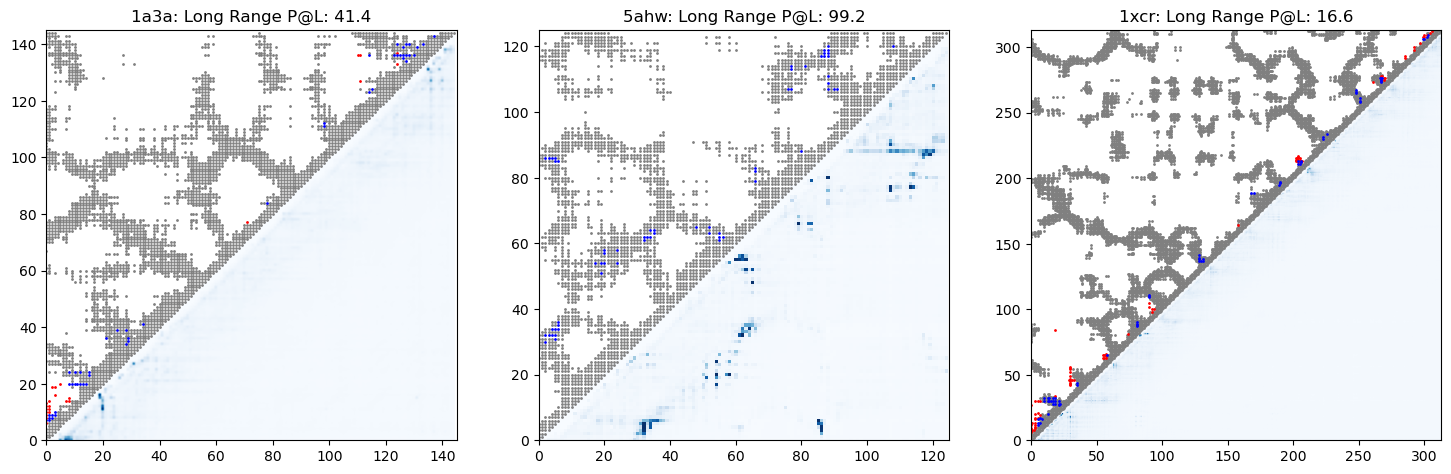

In [12]:
# Generated from the original repo boiler plate code and .a3m data (esm.pretrained.esm2_t6_8M_UR50D() with 15.0 angstrom threshold)

fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

# Check the model's layers

In [14]:
# Inspect ESM-2's layers to see what layers need to be fine-tuned

model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

# model.eval() - only disables batch normalisation and dropout, not parameters 

print(model)

for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")
    
# What is elementwise_affine=True in the models layers?

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

# Use ESMStructuralSplitDataset for pilot

In [15]:
from pathlib import Path
from esm.data import ESMStructuralSplitDataset

# Download structural holdout datasets
for split_level in ['family', 'superfamily', 'fold']:
    for cv_partition in ['0', '1', '2', '3', '4']:
        esm_structural_train = ESMStructuralSplitDataset(
            split_level=split_level, 
            cv_partition=cv_partition, 
            split='train', 
            root_path = os.path.expanduser('~/.cache/torch/data/esm'),
            download=True
        )
        esm_structural_valid = ESMStructuralSplitDataset(
            split_level=split_level, 
            cv_partition=cv_partition, 
            split='valid', 
            root_path = os.path.expanduser('~/.cache/torch/data/esm'),
            download=True
        )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

In [16]:
# Check first sequences in training and validation data (https://github.com/facebookresearch/esm/blob/main/examples/esm_structural_dataset.ipynb)

esm_structural_train = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

esm_structural_valid = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

elet = esm_structural_train[0]
elev = esm_structural_valid[0]
print(elet.keys()) 
print('sequence', elet['seq'])
print('sequence', elev['seq'])

# Check how many entries in dictionary
print(len(esm_structural_train))
print(len(esm_structural_valid))

dict_keys(['seq', 'ssp', 'dist', 'coords'])
sequence MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG
sequence MATEGMILTNHDHQIRVGVLTVSDSCFRNLAEDRSGINLKDLVQDPSLLGGTISAYKIVPDEIEEIKETLIDWCDEKELNLILTTGGTGFAPRDVTPEATKEVIEREAPGMALAMLMGSLNVTPLGMLSRPVCGIRGKTLIINLPGSKKGSQECFQFILPALPHAIDLLRDAIVKVKEVHDRSHHHHHH
12312
2985


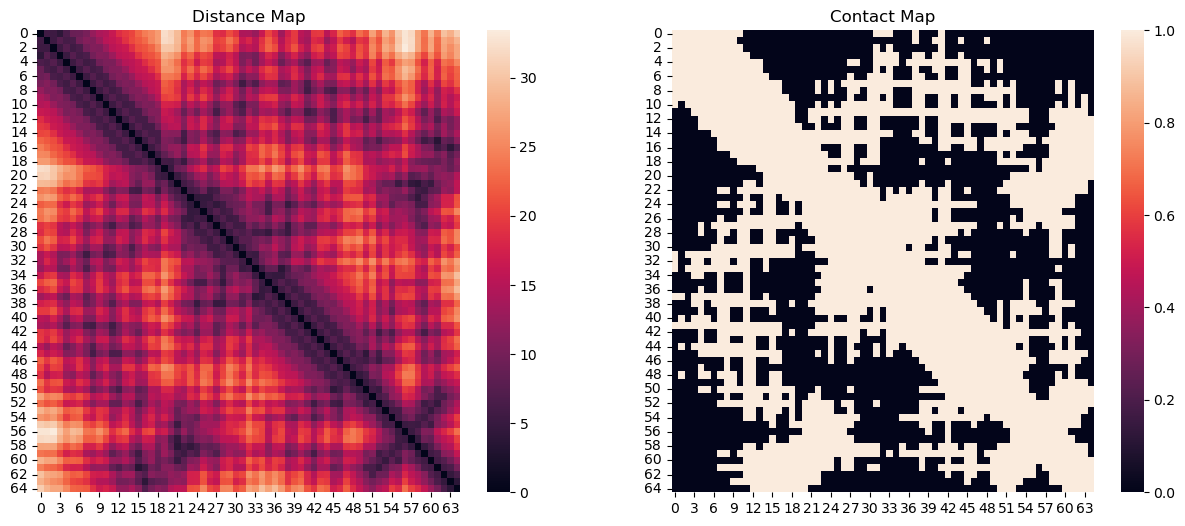

In [17]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(elet['dist'], ax=ax[0])
# Check contacts at 15.0 A
sns.heatmap(elet['dist'] < 15, ax=ax[1])
ax[0].set_title('Distance Map')
ax[1].set_title('Contact Map')
plt.show()

# ESM-2 unsupervised self-attention map contact predictions

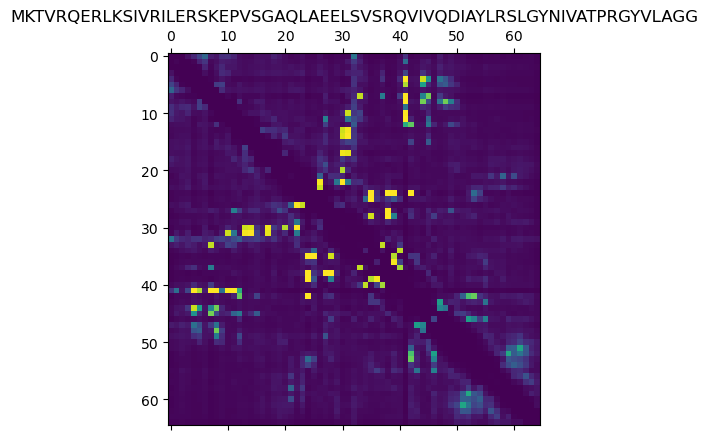

In [18]:
batch_converter = alphabet.get_batch_converter()
# Check the first training sequence
data = [(i, esm_structural_train[i]['seq']) for i in [0]]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
# How do you modify contact distance thresholds to 15 A here?
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)

# Load dataset

In [19]:
from torch.utils.data import DataLoader

# Training dataset downloaded from ESMStructuralSplitDataset
train_dataset = esm_structural_train
valid_dataset = esm_structural_valid

#train_data = [(train_dataset['seq'][i], train_dataset['ssp'][i], train_dataset['dist'][i], train_dataset['coords'][i]) for i in range(len(train_dataset))]

# Maybe the other features of "ssp", "dist" and "coords" not needed for fine-tuning?
# train_data = [(train_dataset['seq'][i] for i in range(len(train_dataset))]


#train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)


# Need to create custom dataset for IDP-complexes afterwards
# Original contact prediction linear regression was trained on 20 amino acids? 
# Load dataset and tokenise with alphabet batch_converter? 

# Fine-tuning & Training loop

In [21]:
import torch.optim as optim
import torch.nn as nn
# Freeze or unfreeze: model.eval() or model.train()

# Last layers of model that might need to be modified/fine-tuned:

# Parameter name: contact_head.regression.weight, Size: torch.Size([1, 120])  -  Maybe we fine-tune this regression parameter
# Parameter name: contact_head.regression.bias, Size: torch.Size([1])  -  Maybe we fine-tune this regression parameter

# Not sure what to do with these other layers, keep these frozen, am I targeting the correct last layers for fine-tuning?

# Parameter name: emb_layer_norm_after.weight, Size: torch.Size([320])
# Parameter name: emb_layer_norm_after.bias, Size: torch.Size([320])
# Parameter name: lm_head.bias, Size: torch.Size([33])
# Parameter name: lm_head.dense.weight, Size: torch.Size([320, 320])
# Parameter name: lm_head.dense.bias, Size: torch.Size([320])
# Parameter name: lm_head.layer_norm.weight, Size: torch.Size([320])
# Parameter name: lm_head.layer_norm.bias, Size: torch.Size([320])

# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

# Modify only the last layer for regression task
model.contact_head.regression = nn.Linear(in_features=120, out_features=1)

# Set requires_grad=True only for the regression layer parameters to be trained
for param in model.contact_head.regression.parameters():
    param.requires_grad = True
    
# Prepare data, optimizer, and objective/loss function

batch_converter = alphabet.get_batch_converter()

# Is just the sequences enough to fine-tune transformer, or should all of the keys in the esm_structural_train dictionary ('ssp', 'dist', 'coords') be included 
# What could be considered the "targets"?
# Avoid feeding in a generator class, maybe load data in a pandas dataframe and work out appropriate inputs and targets
# TypeError: list indices must be integers or slices, not str
train_data = [(i, train_dataset[i]["seq"]) for i in range(len(train_dataset))]


batch_labels, batch_strs, batch_tokens = batch_converter(train_data)
#batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)


In [25]:
batch_tokens

tensor([[ 0, 20, 15,  ...,  1,  1,  1],
        [ 0, 15,  5,  ...,  1,  1,  1],
        [ 0,  6, 16,  ...,  1,  1,  1],
        ...,
        [ 0, 20, 14,  ...,  1,  1,  1],
        [ 0,  6,  8,  ...,  1,  1,  1],
        [ 0,  6,  8,  ...,  1,  1,  1]])

In [ ]:
train_dataloader = DataLoader(batch_tokens, batch_size=16, shuffle=True)
# TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'generator'>

learning_rate = 0.001
               
# Maybe try "AdamW" with weight decay
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# Set objective function. Huber less sensitive to outliers than MSEloss, maybe try MSE as well?        
loss_fn = nn.SmoothL1Loss()
      
# Training loop
num_epochs = 10
               
for epoch in range(num_epochs):
    model.train()
               
    # Initialise loss for each epoch   
    total_loss = 0
    
    for batch in train_dataloader:
        # Sequence inputs
        inputs = batch["batch_tokens"]
        # What are my targets in the dataset, is this just a placeholder to be populated, what key is this representing in my dataset?
        targets = batch["???"]
        # Clear gradients for each epoch
        optimizer.zero_grad()
        # Output predictions for batch 
        outputs = model(inputs)
        # Calculates Huber loss between predictions and true values
        loss = loss_fn(outputs, targets)
        # Pool loss values from each batch
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Updates last layer parameters to reduce loss
        optimizer.step()
    
    # Print loss per batch for the epoch 
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

# Validation & Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Need to decide what keys in the dictionary are relevant
valid_data = [(i, train_dataset[i]["seq"]) for i in range(len(valid_dataset))]
batch_labels, batch_strs, batch_tokens = batch_converter(valid_data)                           
valid_dataloader = DataLoader(batch_tokens, batch_size=16, shuffle=False)

# Set evaluation mode for dropout and batch normalisation
model.eval()

# Initialise lists               
predictions = []
true_contacts = []

# Turn off gradients for evaluation
with torch.no_grad(): 
    for batch in valid_dataloader:
        inputs = batch["batch_tokens"]
        targets = batch["???"]
        
        outputs = model(inputs)
        
        predictions.extend(outputs.tolist())
        true_contacts.extend(targets.tolist())

# Convert lists into tensors
predictions = torch.tensor(predictions)
true_contacts = torch.tensor(true_contacts)

# Evaluation metrics
accuracy = accuracy_score(true_contacts, predictions)
precision = precision_score(true_contacts, predictions)
recall = recall_score(true_contacts, predictions)
f1 = f1_score(true_contacts, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")